In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('darkgrid')
# import cv2
import itertools

import tensorflow as tf
import keras.layers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation,Dropout,Input,concatenate,GlobalAveragePooling2D,Reshape
from keras.layers import ReLU, Add,BatchNormalization, MultiHeadAttention
from keras.models import Model, Sequential
# from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy, Precision, Recall, AUC, SensitivityAtSpecificity, SpecificityAtSensitivity,F1Score,TopKCategoricalAccuracy
from sklearn.metrics import confusion_matrix,classification_report
import imageio
import matplotlib.image as img
import keras.backend as K

import os 
import pathlib 

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.applications import imagenet_utils

In [41]:
# using the Kaggle cloud platform
path = pathlib.Path("/kaggle/input/rice-image-dataset/Rice_Image_Dataset")

In [42]:
arborio = list(path.glob('Arborio/*'))[:1000]
basmati = list(path.glob('Basmati/*'))[:1000]
ipsala = list(path.glob('Ipsala/*'))[:1000]
jasmine = list(path.glob('Jasmine/*'))[:1000]
karacadag = list(path.glob('Karacadag/*'))[:1000]

In [43]:
data = {
    'arborio' : arborio,
    'basmati' : basmati,
    'ipsala' : ipsala,
    'jasmine' : jasmine,
    'karacadag': karacadag
}
rice_labels= {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3:"Jasmine",
    4:"Karacadag"}

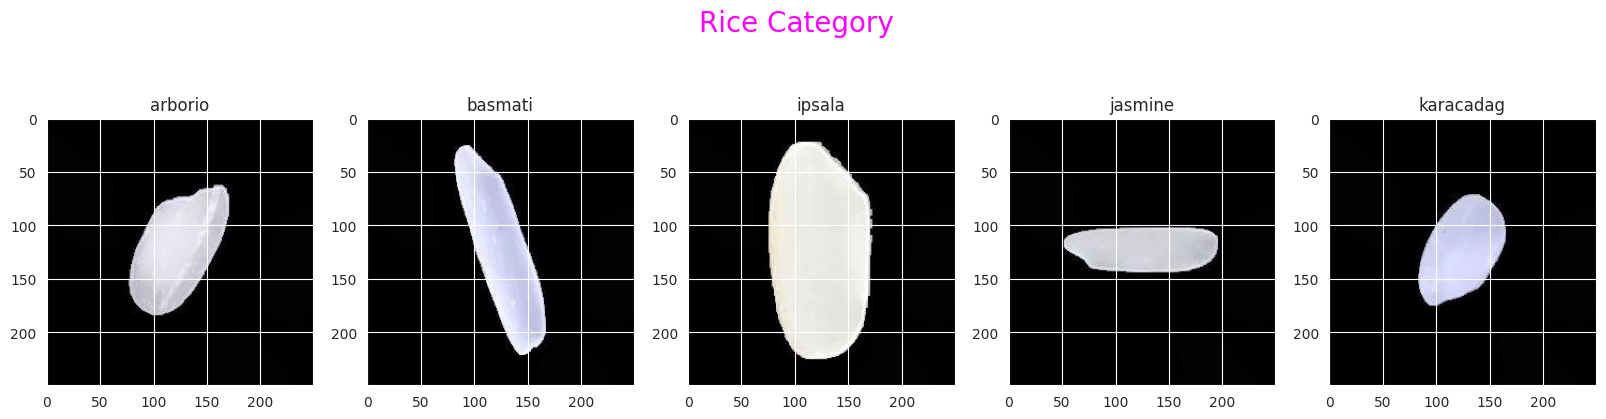

In [44]:
fig, ax = plt.subplots(ncols=5, figsize=(20,5))
fig.suptitle('Rice Category',color='magenta',fontsize=20)
arborio_img = img.imread(arborio[0])
basmati_img = img.imread(basmati[0])
ipsala_img = img.imread(ipsala[0])
jasmine_img = img.imread(jasmine[0])
karacadag_img = img.imread(karacadag[0])

for index,name in enumerate(list(data.keys())):
    ax[index].set_title(name)
ax[0].imshow(arborio_img)
ax[1].imshow(basmati_img)
ax[2].imshow(ipsala_img)
ax[3].imshow(jasmine_img)
ax[4].imshow(karacadag_img)

# Prepocessing the data, and Split the data set with 0.7:0.15:0.15

In [45]:
train_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.15, 
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Create the train generator with 70% of the data
train_data = train_datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Create the validation generator with 15% of the data
validation_data = train_datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# Create the test generator with the remaining 15% of the data
test_data = train_datagen.flow_from_directory(
    path,
    target_size=(128, 128),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # use the 'validation' subset for the test set
)



Found 63750 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [46]:
X_train_batches = []
Y_train_batches = []

for _ in range(250):
    X_batch, Y_batch = next(train_data)
    X_train_batches.append(X_batch)
    Y_train_batches.append(Y_batch)

x_train = np.concatenate(X_train_batches)
y_train = np.concatenate(Y_train_batches)

In [47]:
X_train_batches = []
Y_train_batches = []

for _ in range(250):
    X_batch, Y_batch = next(test_data)
    X_train_batches.append(X_batch)
    Y_train_batches.append(Y_batch)

x_validation = np.concatenate(X_train_batches)
y_validation = np.concatenate(Y_train_batches)

# define the attention block

In [ ]:
#an error encountered in this cell
def self_attention_block(x, num_heads=8, key_dim=64):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, value_dim=None)([x, x, x])
    x = Add()([x, attention_output])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

# first model

In [48]:
def inception_block(input_shape, filter_1x1):
    
    # First branch
    branch_1_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_shape)

    # Second branch
    branch_2_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_2_conv_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(branch_2_conv_1x1)
    branch_2_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_2_conv_3x3)

    # Third branch
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_3_conv_5x5 = Conv2D(96, (5,5), padding='same', activation='relu')(branch_3_conv_1x1 )
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(branch_3_conv_5x5)

    branch_output = concatenate([branch_1_conv_1x1, branch_2_conv_1x1, branch_3_conv_1x1], axis=-1)
    
    return branch_output

In [49]:
input_shape = Input(shape=(128,128,3))
x = Conv2D(64, (7,7), activation='relu')(input_shape)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(32, (1,1), activation='relu')(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)

#x = self_attention_block(x)

x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)

In [50]:
model_1 = Model(inputs=input_shape, outputs=output)

In [51]:
#model_1.summary()

In [52]:
#model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history = model_1.fit_generator(train_data, epochs=4, validation_data=validation_data)

# second model

In [53]:
def res_block(input_shape, filters, strides=1):
    #
    shortcut = input_shape

    x = Conv2D(filters, (1,1), strides=1, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters*4, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    # Skip connection
    if strides !=1 or shortcut.shape[-1]!= filters*4:
        shortcut = Conv2D(filters*4, (1,1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

In [54]:
input_shape = Input(shape=(128,128,3))

# Build a simple ResNet with two residual blocks
x = Conv2D(64, (7,7), strides=2, padding='same')(input_shape)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=64, strides=1)
x = res_block(x, filters=64, strides=1)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=128, strides=1)
x = res_block(x, filters=128, strides=1)
x = MaxPooling2D(2,2)(x)

#x = self_attention_block(x)

x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)

In [55]:
model_2 = Model(inputs=input_shape, outputs=output)

In [56]:
#model_2.summary()

In [57]:
#model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# #ensemble

In [58]:
concatenated_output= concatenate([model_1.output, model_2.output])

In [59]:
x = Dense(200, activation='relu')(concatenated_output)
x = Dense(100, activation='relu')(x)
ensemble_output = Dense(5, activation='softmax')(x)

In [60]:
ensemble_model = Model(inputs=[model_1.input, model_2.input] , outputs= ensemble_output)

# Define the Crossentropy function

In [61]:
def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-15  # Small value to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    return -tf.reduce_sum(y_true * tf.math.log(y_pred)) / tf.cast(tf.shape(y_true)[0], dtype=tf.float32)

# Define the accuracy function

In [62]:
def custom_accuracy(y_true, y_pred):
    correct_predictions = tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
    return tf.reduce_mean(tf.cast(correct_predictions, dtype=tf.float32))

# define the learning rate

In [ ]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_learning_rate = 0.001
    decay = 0.9
    lr = initial_learning_rate * decay**(epoch // 5)
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Complie the model

In [64]:
ensemble_model.compile(optimizer='adam', loss=custom_categorical_crossentropy, 
                       metrics=[custom_accuracy, 
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc-roc'),
        SensitivityAtSpecificity(0.8),
        SpecificityAtSensitivity(0.8),
        TopKCategoricalAccuracy(k=3),
        F1Score()
        ])

In [65]:
ensemble_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_63 (Conv2D)          (None, 64, 64, 64)           9472      ['input_4[0][0]']             
                                                                                                  
 batch_normalization_15 (Ba  (None, 64, 64, 64)           256       ['conv2d_63[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_13 (ReLU)             (None, 64, 64, 64)           0         ['batch_normalization_15

# Fit the model

In [ ]:
history = ensemble_model.fit(
        [x_train,x_train], y_train, # Provide the generator directly
        epochs=15,
        validation_data=([x_validation,x_validation],y_validation),callbacks = [lr_scheduler])

above the learning rate seems encountered errors.

In [66]:
history = ensemble_model.fit(
        [x_train,x_train], y_train, # Provide the generator directly
        epochs=15,
        validation_data=([x_validation,x_validation],y_validation))

Epoch 1/15
250/250 [==============================] - 69s 198ms/step - loss: 1.3457 - custom_accuracy: 0.3890 - precision: 0.8452 - recall: 0.1112 - auc-roc: 0.7366 - sensitivity_at_specificity_2: 0.4726 - specificity_at_sensitivity_2: 0.5130 - top_k_categorical_accuracy: 0.7904 - f1_score: 0.3577 - val_loss: 1.2338 - val_custom_accuracy: 0.4119 - val_precision: 0.9249 - val_recall: 0.1924 - val_auc-roc: 0.7792 - val_sensitivity_at_specificity_2: 0.5211 - val_specificity_at_sensitivity_2: 0.5331 - val_top_k_categorical_accuracy: 0.7977 - val_f1_score: 0.3044
Epoch 2/15
250/250 [==============================] - 41s 165ms/step - loss: 1.1072 - custom_accuracy: 0.4744 - precision: 0.9194 - recall: 0.1896 - auc-roc: 0.8258 - sensitivity_at_specificity_2: 0.6263 - specificity_at_sensitivity_2: 0.6811 - top_k_categorical_accuracy: 0.8755 - f1_score: 0.4340 - val_loss: 1.1137 - val_custom_accuracy: 0.5060 - val_precision: 0.7649 - val_recall: 0.2074 - val_auc-roc: 0.8332 - val_sensitivity_at

# Show the metrics

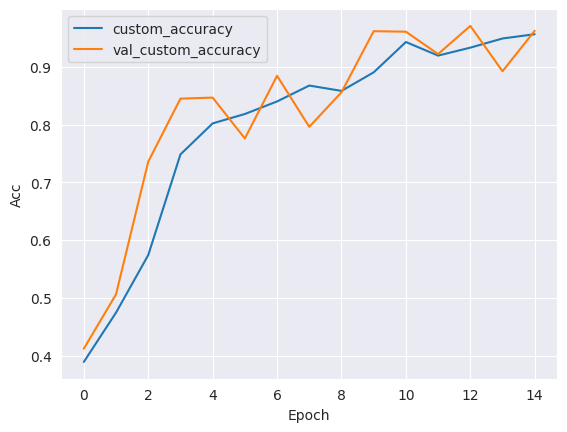

In [67]:
plt.plot(history.history['custom_accuracy'], label='custom_accuracy')
plt.plot(history.history['val_custom_accuracy'], label='val_custom_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

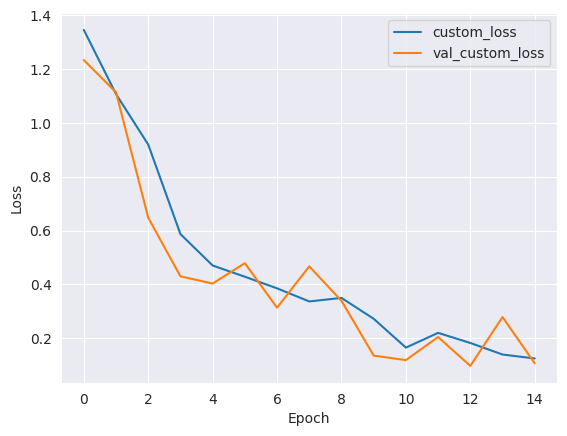

In [68]:
plt.plot(history.history['loss'], label='custom_loss')
plt.plot(history.history['val_loss'], label='val_custom_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

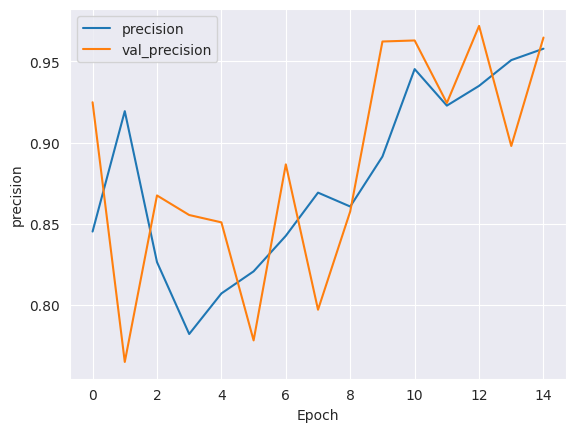

In [69]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.show()

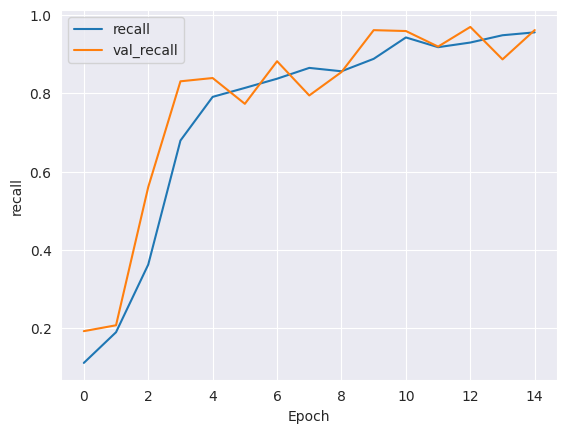

In [70]:
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()
plt.show()

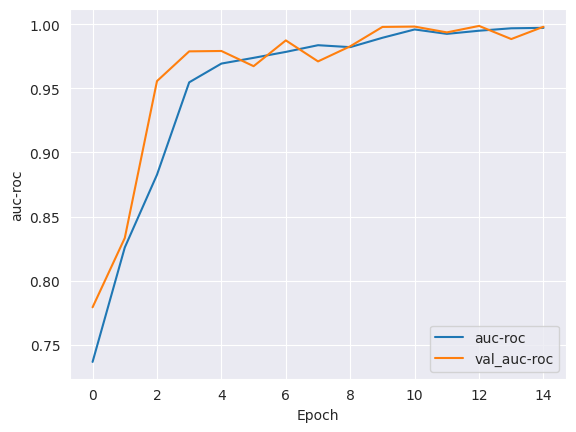

In [71]:
plt.plot(history.history['auc-roc'], label='auc-roc')
plt.plot(history.history['val_auc-roc'], label='val_auc-roc')
plt.xlabel('Epoch')
plt.ylabel('auc-roc')
plt.legend()
plt.show()

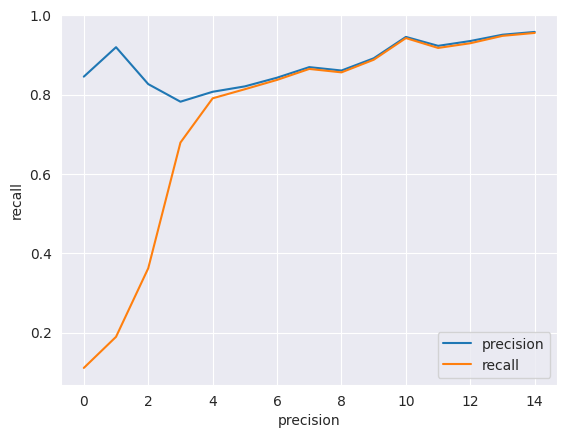

In [72]:
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['recall'], label='recall')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend()
plt.show()

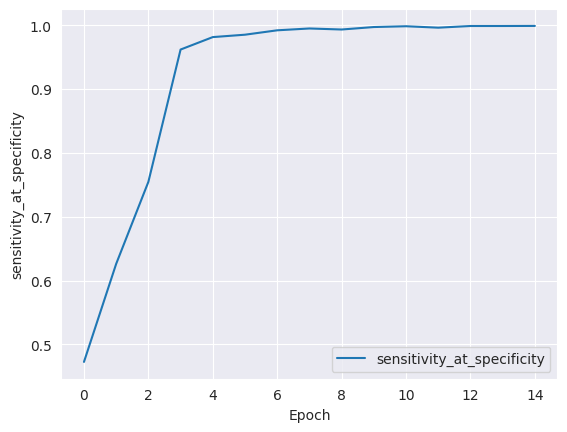

In [75]:
plt.plot(history.history['sensitivity_at_specificity_2'], label='sensitivity_at_specificity')
#plt.plot(history.history['val_custom_accuracy'], label='val_custom_accuracy')
plt.xlabel('Epoch')
plt.ylabel('sensitivity_at_specificity')
plt.legend()
plt.show()

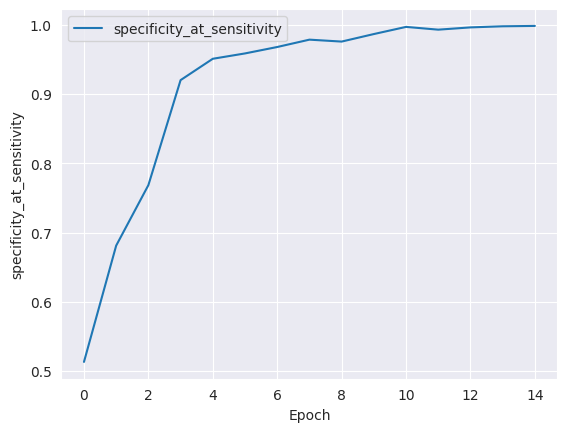

In [76]:
plt.plot(history.history['specificity_at_sensitivity_2'], label='specificity_at_sensitivity')
#plt.plot(history.history['val_custom_accuracy'], label='val_custom_accuracy')
plt.xlabel('Epoch')
plt.ylabel('specificity_at_sensitivity')
plt.legend()
plt.show()

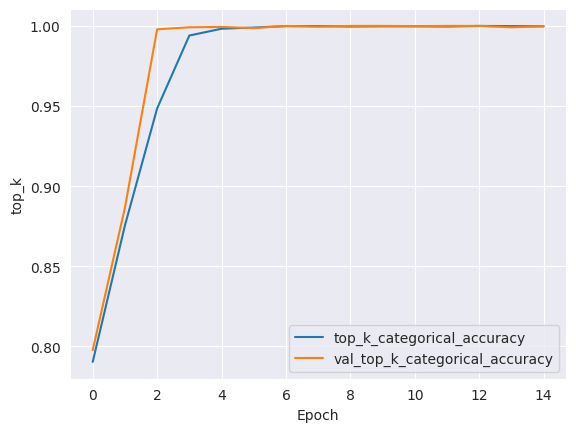

In [78]:
plt.plot(history.history['top_k_categorical_accuracy'], label='top_k_categorical_accuracy')
plt.plot(history.history['val_top_k_categorical_accuracy'], label='val_top_k_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('top_k')
plt.legend()
plt.show()

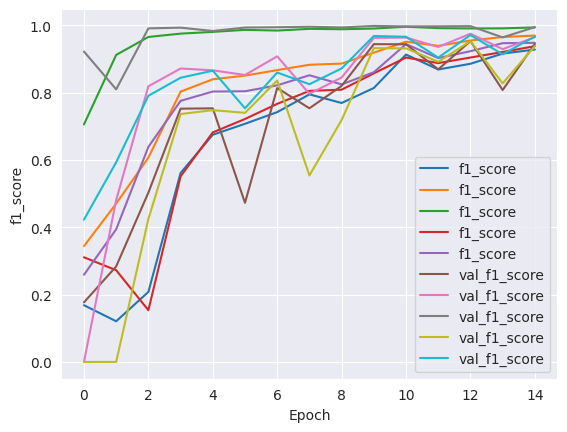

In [79]:
f1_score
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend()
plt.show()


# The evaluate

In [77]:
metrics = ensemble_model.evaluate([x_validation,x_validation],y_validation)

8/8 [==============================] - 1s 55ms/step - loss: 0.2048 - custom_accuracy: 0.9318 - precision: 0.9317 - recall: 0.9280 - auc-roc: 0.9928 - sensitivity_at_specificity_2: 0.9960 - specificity_at_sensitivity_2: 0.9930 - top_k_categorical_accuracy: 1.0000 - f1_score: 0.1930


In [ ]:
print(len(metrics))

In [ ]:
accuracy = metrics[1]
precision = metrics[2]
recall = metrics[3]
f1_score = 2 * (precision * recall) / (precision + recall)
customer_crossentropy_loss = metrics[0]
auc = metrics[4]

print("accuracy:",accuracy)
print("crossentropy_loss:",customer_crossentropy_loss)
print("precision:",precision)
print("recall:",recall)
print("f1_score:",f1_score)
print("auc:",auc)
